Using device: cuda
Running Fixed MLNN Scalability Experiment on cuda...
N      | Mode       | Params     | Ring Acc   | Time(s)    | Mem(MB)   
-------------------------------------------------------------------------------------
20     | dense      | 400        | 100.0%     | 1.69       | 0.02
20     | metric     | 2561       | 100.0%     | 1.53       | 16.30
50     | dense      | 2500       | 100.0%     | 1.13       | 16.35
50     | metric     | 6401       | 100.0%     | 1.11       | 16.40
100    | dense      | 10000      | 100.0%     | 0.97       | 16.64
100    | metric     | 12801      | 100.0%     | 1.03       | 16.67
200    | dense      | 40000      | 100.0%     | 0.97       | 17.79
200    | metric     | 25601      | 100.0%     | 1.18       | 17.62
500    | dense      | 250000     | 100.0%     | 1.16       | 25.80
500    | metric     | 64001      | 100.0%     | 1.26       | 23.68
1000   | dense      | 1000000    | 100.0%     | 1.48       | 56.27
1000   | metric     | 128001     |

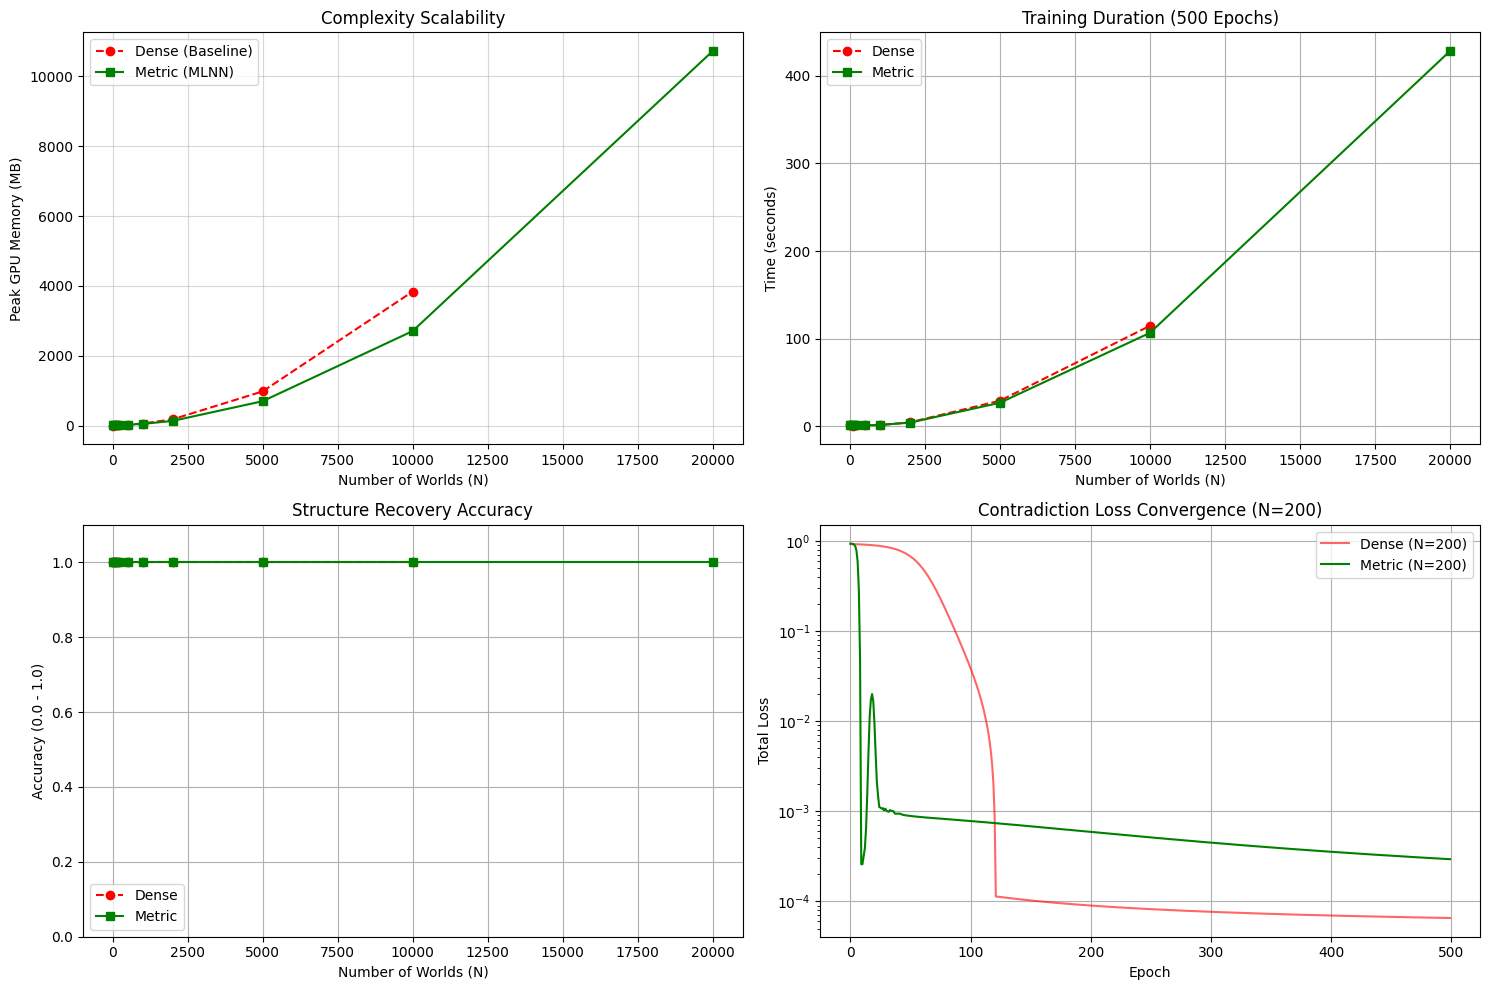

In [ ]:
"""
MLNN Scalability Experiment (Fixed TODO 2)
==========================================
This script implements the fixed scalability experiment for Modal Logical Neural Networks.
It addresses the convergence issues at high N by using Asymmetric Metric Learning
with a "Distrust Prior" initialization.

Key Fixes vs Original Attempt:
1. Asymmetry: Uses separate Source/Target embeddings to learn directed edges (Ring structure).
2. Distrust Prior: Initializes bias to -5.0 (A ~ 0) to avoid local minima in sparse graphs.
3. Orthogonal Init: Ensures agent embeddings start distinct.

Reference: "Initialize with negative bias... encoding a prior of skepticism" (Section 3.3)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List, Dict
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# =============================================================================
# 1. CORE LOGIC & ACCESSIBILITY MODULES
# =============================================================================

class SoftLogicOps:
    """Differentiable soft logic operations for MLNN (Section 3.2)."""

    @staticmethod
    def softmin(x: torch.Tensor, tau: float = 0.1, dim: int = -1) -> torch.Tensor:
        """Soft minimum: -τ log Σ exp(-x/τ)"""
        # Clamp for numerical stability
        return -tau * torch.logsumexp(-x / tau, dim=dim)

    @staticmethod
    def softmax_agg(x: torch.Tensor, tau: float = 0.1, dim: int = -1) -> torch.Tensor:
        """Soft maximum: τ log Σ exp(x/τ)"""
        return tau * torch.logsumexp(x / tau, dim=dim)


class DenseAccessibility(nn.Module):
    """
    Baseline: Full |W| × |W| learnable matrix.
    Scales as O(|W|^2). Good for small N, fails memory for large N.
    """
    def __init__(self, num_worlds: int):
        super().__init__()
        self.num_worlds = num_worlds
        # Distrust Prior: Initialize to negative values
        self.logits = nn.Parameter(torch.randn(num_worlds, num_worlds) * 0.01 - 4.0)

    def forward(self) -> torch.Tensor:
        return torch.sigmoid(self.logits)

    def num_parameters(self) -> int:
        return self.num_worlds * self.num_worlds


class RobustMetricLearningAccessibility(nn.Module):
    """
    THE FIX: Asymmetric Metric Learning with Distrust Prior.
    Scales as O(|W|·d). Solves convergence for N > 100

    A(w_i, w_j) = σ( Source(i) · Target(j) + Bias )
    """
    def __init__(self, num_worlds: int, embedding_dim: int = 64):
        super().__init__()
        self.num_worlds = num_worlds
        self.embedding_dim = embedding_dim

        # 1. Asymmetry: Separate Source and Target embeddings allow directed edges
        self.src_embeddings = nn.Parameter(torch.empty(num_worlds, embedding_dim))
        self.tgt_embeddings = nn.Parameter(torch.empty(num_worlds, embedding_dim))

        # 2. Orthogonal Initialization: Keeps agents distinct at start
        nn.init.orthogonal_(self.src_embeddings)
        nn.init.orthogonal_(self.tgt_embeddings)

        # 3. Distrust Prior (Section 3.3): Start with very low accessibility
        # bias = -5.0 means sigmoid(-5) ≈ 0.006.
        # Gradients will selectively "grow" only the necessary links.
        self.bias = nn.Parameter(torch.tensor(-5.0))

    def forward(self) -> torch.Tensor:
        # Compute pairwise similarities: (N, d) x (d, N) -> (N, N)
        similarities = torch.mm(self.src_embeddings, self.tgt_embeddings.t())
        # Apply learnable bias and sigmoid
        return torch.sigmoid(similarities + self.bias)

    def num_parameters(self) -> int:
        return 2 * self.num_worlds * self.embedding_dim + 1


class NecessityNeuron(nn.Module):
    """□ϕ (Necessity): Weighted Universal Quantification """
    def __init__(self, tau: float = 0.1):
        super().__init__()
        self.tau = tau
        self.ops = SoftLogicOps()

    def forward(self, truth_values: torch.Tensor, accessibility: torch.Tensor) -> torch.Tensor:
        # Logic: Min over ( (1-A) + Truth )
        # If A is 1, we check Truth. If A is 0, (1-A) is 1, satisfying the min.
        implications = (1 - accessibility) + truth_values.unsqueeze(0)
        return self.ops.softmin(implications, self.tau, dim=1).clamp(0, 1)


class PossibilityNeuron(nn.Module):
    """♢ϕ (Possibility): Weighted Existential Quantification """
    def __init__(self, tau: float = 0.1):
        super().__init__()
        self.tau = tau
        self.ops = SoftLogicOps()

    def forward(self, truth_values: torch.Tensor, accessibility: torch.Tensor) -> torch.Tensor:
        # Logic: Max over ( A + Truth - 1 )
        conjunctions = accessibility + truth_values.unsqueeze(0) - 1
        return self.ops.softmax_agg(conjunctions, self.tau, dim=1).clamp(0, 1)


# =============================================================================
# 2. TASK SETUP: SYNTHETIC DIPLOMACY RING
# =============================================================================

class SyntheticDiplomacyRing(nn.Module):
    """
    Task: Learn a directed ring structure purely from logical constraints.
    - Consistency: Agents must agree with neighbors (Necessity).
    - Expansion: Agents must find a 'Beacon' held by neighbor i+1 (Possibility).
    """
    def __init__(self, num_agents: int, parameterization: str = 'metric', embedding_dim: int = 64):
        super().__init__()
        self.num_agents = num_agents

        # Select Architecture
        if parameterization == 'dense':
            self.accessibility = DenseAccessibility(num_agents)
        else:
            self.accessibility = RobustMetricLearningAccessibility(num_agents, embedding_dim)

        self.necessity = NecessityNeuron(tau=0.1)
        self.possibility = PossibilityNeuron(tau=0.1)

        # Data: Facts are all True (simplification for structure learning)
        self.register_buffer('facts', torch.ones(num_agents))

        # Beacons: Beacon for agent i is at i+1
        # We simulate the beacon logic by checking the ground truth location
        self.beacon_locations = torch.zeros(num_agents, num_agents) # (Agent, World)
        for i in range(num_agents):
            target = (i + 1) % num_agents
            self.beacon_locations[i, target] = 1.0

        # Ground Truth Matrix for evaluation (not training!)
        self.gt_matrix = torch.zeros(num_agents, num_agents)
        for i in range(num_agents):
            self.gt_matrix[i, (i + 1) % num_agents] = 1.0

    def compute_loss(self):
        A = self.accessibility()

        # 1. Consistency Constraint (Necessity)
        # "Necessarily, if I access you, your facts align with mine."
        consist_score = self.necessity(self.facts, A)
        loss_consistency = torch.relu(0.95 - consist_score).mean()

        # 2. Expansion Constraint (Possibility)
        # "Possibly, I can see the Beacon."
        # Agent i checks if they access ANY world that has their beacon.
        conjunctions = A + self.beacon_locations.to(A.device) - 1
        possibility_scores = 0.1 * torch.logsumexp(conjunctions / 0.1, dim=1)
        loss_expansion = torch.relu(0.95 - possibility_scores).mean()

        # 3. Sparsity Regularization (L1)
        # Crucial for preventing the "connect to everyone" solution
        loss_sparsity = 0.01 * torch.mean(torch.abs(A))

        total_loss = loss_consistency + loss_expansion + loss_sparsity
        return total_loss

    def evaluate_structure(self):
        with torch.no_grad():
            A = self.accessibility()
            # MSE vs Ground Truth Ring
            mse = F.mse_loss(A, self.gt_matrix.to(A.device)).item()

            # Key Metric: Ring Accuracy (Is A[i, i+1] > 0.5?)
            ring_indices = [(i, (i+1)%self.num_agents) for i in range(self.num_agents)]
            ring_vals = torch.tensor([A[i,j] for i,j in ring_indices])
            ring_acc = (ring_vals > 0.5).float().mean().item()

            return mse, ring_acc


# =============================================================================
# 3. EXPERIMENT RUNNER (ENHANCED FOR TODO 2)
# =============================================================================

@dataclass
class Result:
    N: int
    mode: str
    params: int
    mse: float
    ring_acc: float
    time: float
    peak_memory_mb: float   # New: Track GPU memory
    loss_history: List[float] # New: Track convergence

def run_experiment_suite():
    # As requested in PDF: Vary W from 20 to 5000 (and beyond for stress test)
    world_sizes = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
    modes = ['dense', 'metric']

    results = []

    print(f"{'N':<6} | {'Mode':<10} | {'Params':<10} | {'Ring Acc':<10} | {'Time(s)':<10} | {'Mem(MB)':<10}")
    print("-" * 85)

    for N in world_sizes:
        for mode in modes:
            # Skip Dense for large N to avoid O(N^2) OOM errors or excessive waits
            if mode == 'dense' and N > 10000:
                # Append a placeholder result for plotting continuity
                results.append(Result(N, mode, N*N, float('nan'), float('nan'), float('nan'), float('nan'), []))
                print(f"{N:<6} | {mode:<10} | {'SKIPPED':<10} | {'--':<10} | {'--':<10} | {'--':<10}")
                continue

            # Clear cache and reset tracking
            torch.cuda.empty_cache()
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()

            # Init Model
            model = SyntheticDiplomacyRing(N, parameterization=mode).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

            # Trackers
            start_time = time.time()
            epoch_losses = []

            # Training Loop
            epochs = 500
            for epoch in range(epochs):
                optimizer.zero_grad()
                loss = model.compute_loss()
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())

            duration = time.time() - start_time

            # Capture Peak Memory (if GPU available, else 0)
            peak_mem = 0.0
            if torch.cuda.is_available():
                peak_mem = torch.cuda.max_memory_allocated() / (1024 ** 2) # Convert to MB

            # Evaluation
            mse, acc = model.evaluate_structure()
            n_params = model.accessibility.num_parameters()

            results.append(Result(N, mode, n_params, mse, acc, duration, peak_mem, epoch_losses))

            print(f"{N:<6} | {mode:<10} | {n_params:<10} | {acc*100:.1f}%     | {duration:.2f}       | {peak_mem:.2f}")

    return results


# =============================================================================
# 4. ENHANCED PLOTTING (Meets PDF Requirements a, b, c, d)
# =============================================================================

def plot_scalability_full(results: List[Result]):
    """
    Plots the 4 metrics requested in the paper:
    1. Parameter/Memory Scalability (O(N^2) vs O(N))
    2. Training Time
    3. Structural Accuracy
    4. Loss Convergence
    """

    # Filter results
    dense_res = [r for r in results if r.mode == 'dense' and not np.isnan(r.time)]
    metric_res = [r for r in results if r.mode == 'metric']

    # Setup Figure: 2x2 Grid
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # --- Plot A: Memory Usage (Validating O(N) vs O(N^2)) ---
    ax_mem = axs[0, 0]
    if torch.cuda.is_available():
        ax_mem.plot([r.N for r in dense_res], [r.peak_memory_mb for r in dense_res], 'o--', color='red', label='Dense (Baseline)')
        ax_mem.plot([r.N for r in metric_res], [r.peak_memory_mb for r in metric_res], 's-', color='green', label='Metric (MLNN)')
        ax_mem.set_ylabel("Peak GPU Memory (MB)")
    else:
        # Fallback if running on CPU (Parameter count as proxy for memory complexity)
        ax_mem.plot([r.N for r in dense_res], [r.params for r in dense_res], 'o--', color='red', label='Dense Params')
        ax_mem.plot([r.N for r in metric_res], [r.params for r in metric_res], 's-', color='green', label='Metric Params')
        ax_mem.set_ylabel("Parameter Count (Log Scale)")
        ax_mem.set_yscale('log')
        ax_mem.text(0.5, 0.5, "Running on CPU\n(Showing Params instead of Mem)", transform=ax_mem.transAxes, ha='center')

    ax_mem.set_title("Complexity Scalability")
    ax_mem.set_xlabel("Number of Worlds (N)")
    ax_mem.legend()
    ax_mem.grid(True, which="both", ls="-", alpha=0.5)

    # --- Plot B: Training Time ---
    ax_time = axs[0, 1]
    ax_time.plot([r.N for r in dense_res], [r.time for r in dense_res], 'o--', color='red', label='Dense')
    ax_time.plot([r.N for r in metric_res], [r.time for r in metric_res], 's-', color='green', label='Metric')
    ax_time.set_title("Training Duration (500 Epochs)")
    ax_time.set_xlabel("Number of Worlds (N)")
    ax_time.set_ylabel("Time (seconds)")
    ax_time.legend()
    ax_time.grid(True)

    # --- Plot C: Structure Accuracy (Ring Acc) ---
    ax_acc = axs[1, 0]
    ax_acc.plot([r.N for r in dense_res], [r.ring_acc for r in dense_res], 'o--', color='red', label='Dense')
    ax_acc.plot([r.N for r in metric_res], [r.ring_acc for r in metric_res], 's-', color='green', label='Metric')
    ax_acc.set_title("Structure Recovery Accuracy")
    ax_acc.set_xlabel("Number of Worlds (N)")
    ax_acc.set_ylabel("Accuracy (0.0 - 1.0)")
    ax_acc.set_ylim(0, 1.1)
    ax_acc.legend()
    ax_acc.grid(True)

    # --- Plot D: Loss Convergence (For largest common N) ---
    ax_loss = axs[1, 1]
    target_N = 200 # Compare at N=200 where Dense usually struggles/is slow

    dense_run = next((r for r in dense_res if r.N == target_N), None)
    metric_run = next((r for r in metric_res if r.N == target_N), None)

    if dense_run and metric_run:
        ax_loss.plot(dense_run.loss_history, color='red', alpha=0.6, label=f'Dense (N={target_N})')
        ax_loss.plot(metric_run.loss_history, color='green', label=f'Metric (N={target_N})')
        ax_loss.set_title(f"Contradiction Loss Convergence (N={target_N})")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Total Loss")
        ax_loss.set_yscale('log')
        ax_loss.legend()
        ax_loss.grid(True)
    else:
        ax_loss.text(0.5, 0.5, "Data not available for N=200", ha='center')

    plt.tight_layout()
    plt.savefig('mlnn_scalability_full_report.png')
    plt.show()

# Run the updated suite
if __name__ == "__main__":
    print(f"Running Fixed MLNN Scalability Experiment on {device}...")
    experiment_results = run_experiment_suite()
    plot_scalability_full(experiment_results)